In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d, gaussian_filter  # Updated import statements
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, fbeta_score, precision_recall_curve,
    average_precision_score, auc
)

In [2]:
import keras.backend as K
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
    BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from inspect import signature


Loading datasets...


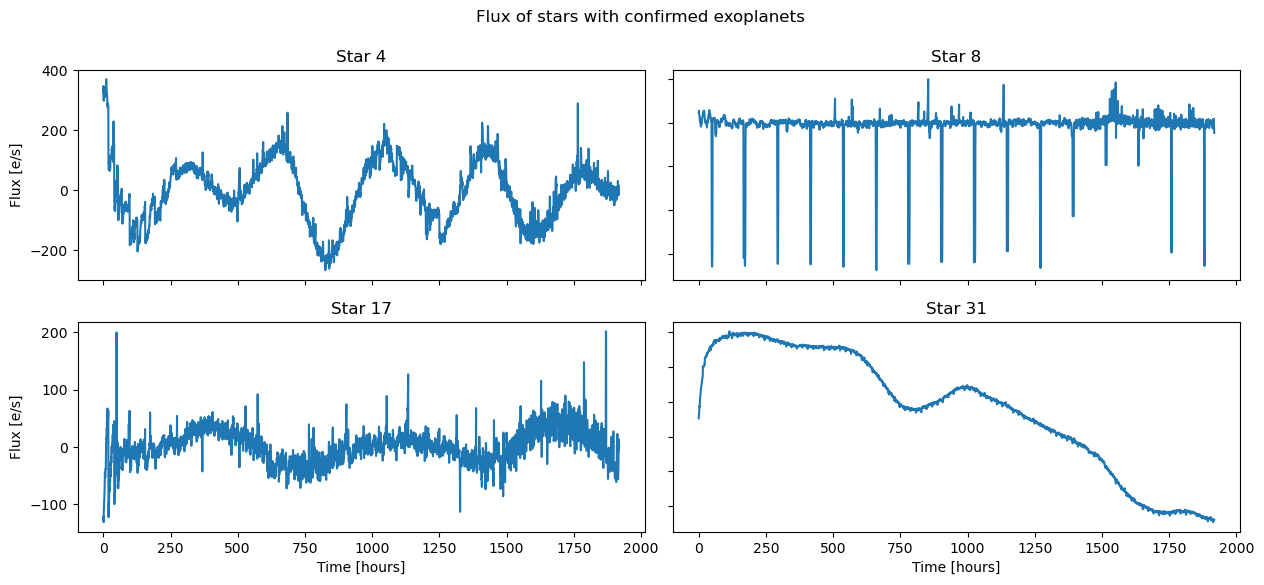

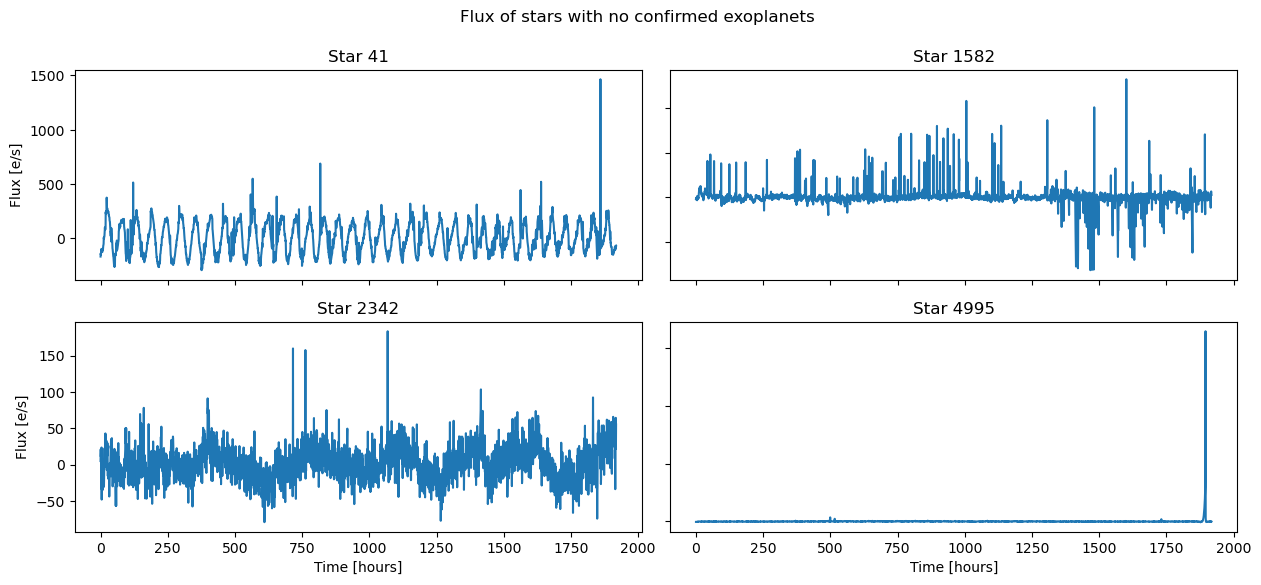

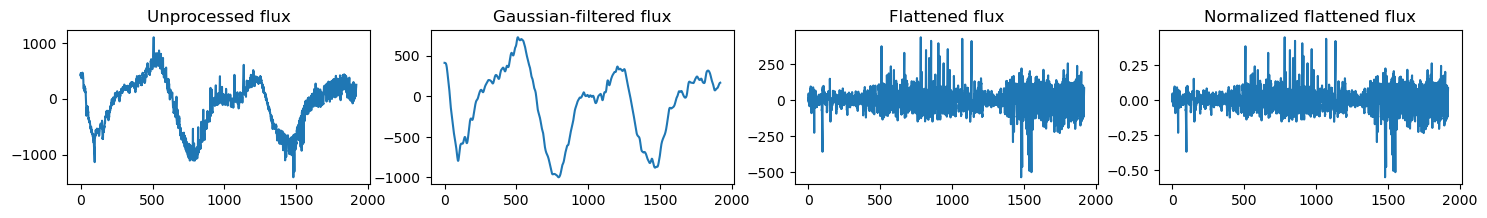

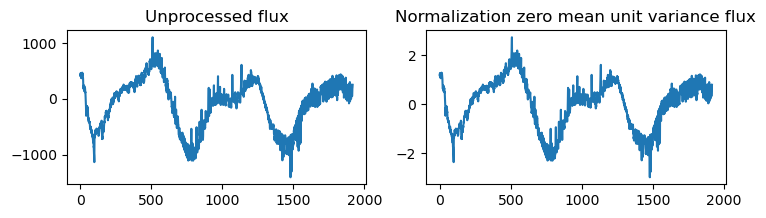

In [3]:
# Define main function
def main():
    # Converting the formate from dataframe to numpy arrays (matrices)
    # and defining x-values and y-values for both the test and training set
    print("Loading datasets...")
    train = pd.read_csv("Data/exoTrain.csv", encoding= "ISO-8859-1") #on data frame format
    test = pd.read_csv("Data/exoTest.csv", encoding= "ISO-8859-1") #on data frame format
    x_train = train.drop('LABEL', axis=1)
    x_test = test.drop('LABEL', axis=1)
    y_train = train.LABEL
    y_test = test.LABEL
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape((-1,1))-1
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape((-1,1))-1 
    
    # Add extra positive examples of light curves by flipping them
    x_train = np.append(x_train, np.flip(x_train[0:37,:], axis=-1), axis=0)
    y_train = np.append(y_train, y_train[0:37]).reshape((-1,1))
    x_test = np.append(x_test, np.flip(x_test[0:5,:], axis=-1), axis=0)
    y_test = np.append(y_test, y_test[0:5]).reshape((-1,1))
    
    # Plot some positive examples
    time = np.arange(len(x_train[0,:])) * (36.0/60.0)
    fig, axs = plt.subplots(2, 2,figsize=(15, 6))
    fig.subplots_adjust(hspace = .2, wspace=.05)
    fig.suptitle('Flux of stars with confirmed exoplanets')
    axs[0, 0].plot(time, x_train[3,:])
    axs[0, 0].set_title('Star 4')
    axs[0, 1].plot(time, x_train[7,:])
    axs[0, 1].set_title('Star 8')
    axs[1, 0].plot(time, x_train[16,:])
    axs[1, 0].set_title('Star 17')
    axs[1, 1].plot(time, x_train[30,:])
    axs[1, 1].set_title('Star 31')

    for ax in axs.flat:
        ax.set(xlabel='Time [hours]', ylabel='Flux [e/s]')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()  
    
    # Plot some negative examples
    time = np.arange(len(x_train[0,:])) * (36.0/60.0)
    fig, axs = plt.subplots(2, 2,figsize=(15, 6))
    fig.subplots_adjust(hspace = .2, wspace=.05)
    fig.suptitle('Flux of stars with no confirmed exoplanets')
    axs[0, 0].plot(time, x_train[40,:])
    axs[0, 0].set_title('Star 41')
    axs[0, 1].plot(time, x_train[1581,:])
    axs[0, 1].set_title('Star 1582')
    axs[1, 0].plot(time, x_train[2341,:])
    axs[1, 0].set_title('Star 2342')
    axs[1, 1].plot(time, x_train[4994,:])
    axs[1, 1].set_title('Star 4995')

    for ax in axs.flat:
        ax.set(xlabel='Time [hours]', ylabel='Flux [e/s]')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
       
    # Plot the preprocessing steps
    flux_unprocessed = x_train[13,:]
    flux_gaussian = gaussian_filter(flux_unprocessed, sigma=10)
    flux_smoothed = flux_unprocessed - flux_gaussian
    flux_normalized = (flux_smoothed-np.mean(flux_smoothed))/(np.max(flux_smoothed)-np.min(flux_smoothed))
    flux_zeromean = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / np.std(x_train, axis=1).reshape(-1,1))
    
    # Detrended preprocessing
    time = np.arange(len(x_train[0,:])) * (36.0/60.0)
    fig, axs = plt.subplots(1, 4,figsize=(18, 2))
    fig.subplots_adjust(hspace = .2, wspace=.2)    
    axs[0].plot(time,flux_unprocessed)
    axs[0].set_title('Unprocessed flux')
    axs[1].plot(time,flux_gaussian)
    axs[1].set_title('Gaussian-filtered flux')
    axs[2].plot(time,flux_smoothed)
    axs[2].set_title('Flattened flux')
    axs[3].plot(time,flux_normalized)
    axs[3].set_title('Normalized flattened flux')
    
    # Zero mean unit variance preprocessing
    fig2, axs = plt.subplots(1, 2,figsize=(8.5,2))
    fig2.subplots_adjust(hspace = .2, wspace=.2)
    axs[0].plot(time,flux_unprocessed)
    axs[0].set_title('Unprocessed flux')
    axs[1].plot(time,flux_zeromean[13,:])
    axs[1].set_title('Normalization zero mean unit variance flux')
main()